In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import timedelta, datetime

# Reflect Tables into SQLAlchemy ORM

In [88]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct, text, desc, alias

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Declare a Base using `automap_base()`
Base = automap_base()

In [7]:
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [8]:
# reflect an existing database into a new model

# reflect the tables

In [9]:
# We can view all of the classes that automap found
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
# Assign the dow class to a variable called `Dow`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x229e4027148>,
 'station': 'USC00519397',
 'tobs': 65.0,
 'prcp': 0.08,
 'date': '2010-01-01',
 'id': 1}

In [13]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x229e40a7b88>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

# Temperature Analysis 2
<p style="color:blue;"> Assume my trip is planned for August 1 through August 10.  The dates I will use to check the data are 2017-08-01 through 2017-08-10.</p>

In [14]:
date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
date = list(np.ravel(date))
date[0]

'2017-08-23'

In [15]:
#latest date in table
last_date = dt.datetime.strptime(date[0],'%Y-%m-%d' )

In [17]:
# Calculate the date 1 year ago from the last data point in the database

first_date = last_date - timedelta(days=365)
first_date

datetime.datetime(2016, 8, 23, 0, 0)

In [20]:
#trip start date
start_date = dt.datetime.strptime('2017-08-01','%Y-%m-%d' )

In [21]:
#trip end date
end_date = dt.datetime.strptime('2017-08-10','%Y-%m-%d' )

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps(start_date, end_date)
print(trip_temps)
tmin, tavg, tmax = np.ravel(trip_temps)
tmin, tavg, tmax

[(71.0, 79.54285714285714, 83.0)]


(71.0, 79.54285714285714, 83.0)

In [50]:
error = np.zeros((2,1))

In [63]:
error[0,0] = tavg - tmin
error[1,0] = tmax - tavg

In [64]:
error

array([[8.54285714],
       [3.45714286]])

<ErrorbarContainer object of 3 artists>

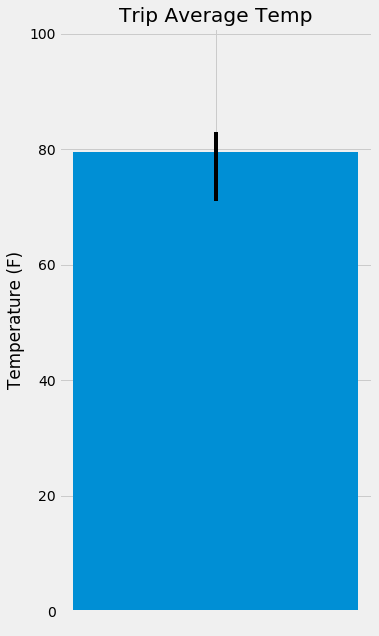

In [68]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
lower_error = tmin
upper_error = tmax
fig = plt.figure(figsize = (5,10))
ax = fig.add_subplot(1,1,1)
plt.bar(x=" ",height=tavg)
ax.set_ylim(0, 101)
ax.set_title("Trip Average Temp")
ax.set_ylabel('Temperature (F)')
ax.errorbar(0,tavg,yerr = error, ecolor = 'black')

In [111]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_total = session.query(Measurement.station, func.sum(Measurement.prcp).label('total_rainfall'), Station.name, Station.latitude, Station.longitude, Station.elevation).filter((Measurement.date >= start_date) & (Measurement.date <= end_date)).filter(Measurement.station == Station.station).group_by(Measurement.station).order_by('total_rainfall').all()
rainfall_total

[('USC00519523',
  0.0,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00519397', 0.02, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519281',
  0.06,
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00514830',
  0.2,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00516128',
  0.9199999999999999,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4)]

In [113]:
rainfall_total_df = pd.DataFrame(rainfall_total)
rainfall_total_df

,station,total_rainfall,name,latitude,longitude,elevation
0,USC00519523,0.00,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
1,USC00519397,0.02,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
2,USC00519281,0.06,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
3,USC00514830,0.20,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,USC00516128,0.92,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [114]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [129]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
print(start_date)
print(end_date)
# Use the start and end date to create a range of dates
date_range = pd.date_range(start_date, end_date).to_list()
print(date_range)
# Stip off the year and save a list of %m-%d strings
date_range_list = [(date.strftime("%m")+ "-" + date.strftime("%d")) for date in date_range]
print(date_range_list)
# Loop through the list of %m-%d strings and calculate the normals for each date
for date in date_range_list:
    print(date, daily_normals(date))

2017-08-01 00:00:00
2017-08-10 00:00:00
[Timestamp('2017-08-01 00:00:00', freq='D'), Timestamp('2017-08-02 00:00:00', freq='D'), Timestamp('2017-08-03 00:00:00', freq='D'), Timestamp('2017-08-04 00:00:00', freq='D'), Timestamp('2017-08-05 00:00:00', freq='D'), Timestamp('2017-08-06 00:00:00', freq='D'), Timestamp('2017-08-07 00:00:00', freq='D'), Timestamp('2017-08-08 00:00:00', freq='D'), Timestamp('2017-08-09 00:00:00', freq='D'), Timestamp('2017-08-10 00:00:00', freq='D')]
['08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07', '08-08', '08-09', '08-10']
08-01 [(67.0, 75.54, 83.0)]
08-02 [(68.0, 75.60377358490567, 84.0)]
08-03 [(70.0, 76.61111111111111, 85.0)]
08-04 [(69.0, 76.71153846153847, 84.0)]
08-05 [(69.0, 76.14814814814815, 82.0)]
08-06 [(67.0, 76.25, 83.0)]
08-07 [(71.0, 77.15686274509804, 83.0)]
08-08 [(68.0, 76.5576923076923, 83.0)]
08-09 [(69.0, 75.98039215686275, 81.0)]
08-10 [(65.0, 76.42, 83.0)]


In [137]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_normals= {}
for date in date_range_list:
    date_normals = {}
    date_normals['min_T'], date_normals['avg_T'], date_normals['max_T'] = daily_normals(date)[0]
    trip_normals[date] = date_normals
    

In [141]:
trip_normals_df = pd.DataFrame(trip_normals).T

In [142]:
trip_normals_df

,min_T,avg_T,max_T
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0
08-08,68.0,76.557692,83.0
08-09,69.0,75.980392,81.0
08-10,65.0,76.420000,83.0


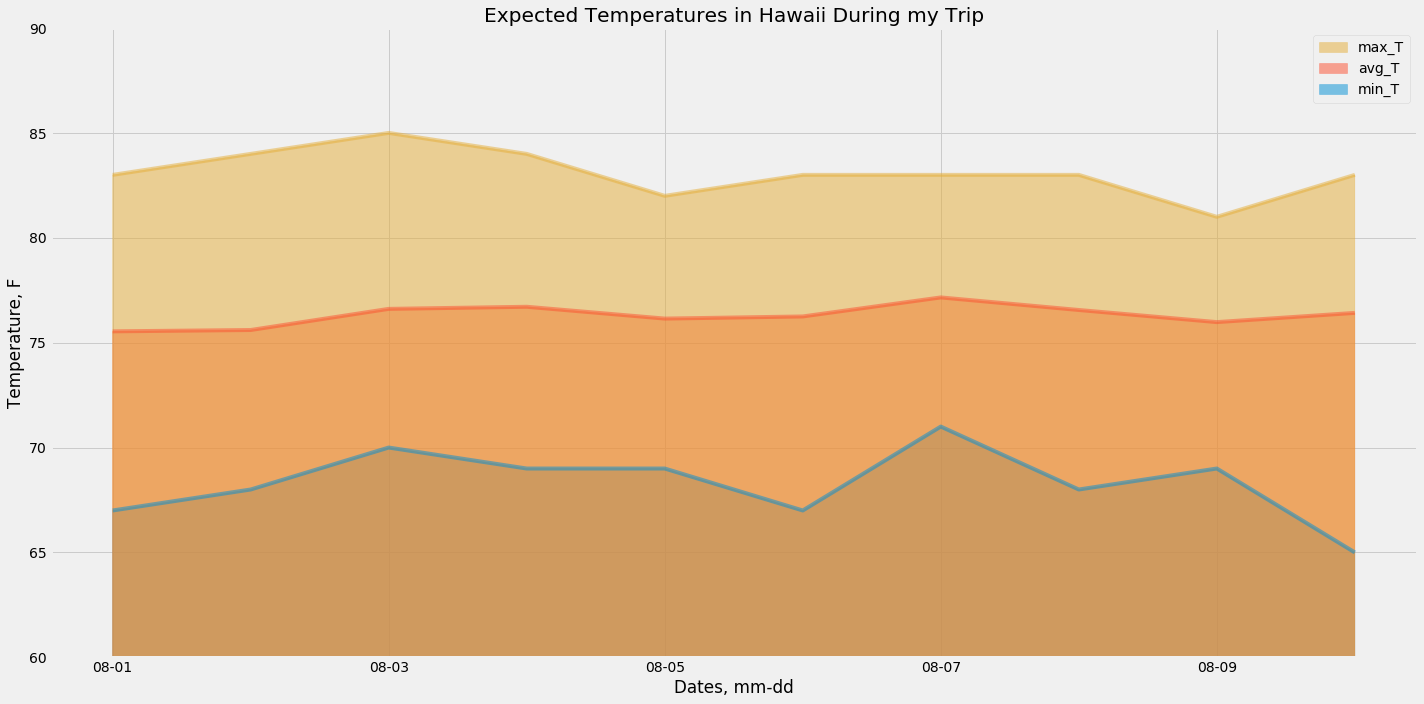

In [154]:
# Plot the daily normals as an area plot with `stacked=False`
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1,1,1)
trip_normals_df.plot(kind = 'area', ax=ax, stacked = False)
ax.set_title("Expected Temperatures in Hawaii During my Trip")
ax.set_ylabel("Temperature, F")
ax.set_xlabel("Dates, mm-dd")
ax.set_ylim(60, 90)
plt.tight_layout()
plt.savefig('./Images/holiday_temperatures.png')
#The list order should have the same length as the number of legend items, and specifies the new order manually.
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])